In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('balletmasters_final.csv')
df_link = pd.read_csv('balletmasters_numoflink.csv')
df = pd.merge(df_link,df,left_on='Name', right_on='ballet_master')
# df = df[['Name','num_links','num_awards','num_countries','num_influences','num_employer','num_education','gender','birth_year']]
# df = df.dropna()
df = df[df['num_awards'] != 0]

In [3]:
df

,Name,QID,num_links,ballet_master,country_of_citizenship,employer,birth_year,gender,educatedat,studentofLabel,studentLabel,influence,award,num_awards,num_countries,num_influences,num_employer,num_education
0,Çimnaz Babayeva,Q12848543,2.0,Çimnaz Babayeva,Azerbaijan; Russia,Azerbaijan State Academic Opera and Ballet The...,1946.0,female,Azerbaijan State Academic Opera and Ballet The...,NaN,NaN,NaN,Honored Artist of the Azerbaijan SSR; People's...,3,2,0,1,2
1,Éric Vu-An,Q3591402,7.0,Éric Vu-An,France,NaN,1964.0,male,Paris Opera,NaN,NaN,NaN,Officer of the Legion of Honour; Knight of the...,5,1,0,0,1
2,Éva Gaál,Q109781409,3.0,Éva Gaál,Hungary,NaN,1930.0,female,NaN,Ferenc Nádasi,NaN,Ferenc Nádasi,Franz Liszt Prize; Meritorius Artist of Hungary,2,1,1,0,0
6,Adél Orosz,Q1225751,3.0,Adél Orosz,Hungary,NaN,1938.0,female,NaN,NaN,NaN,NaN,Great Artist of Hungary Award; Kossuth Prize; ...,6,1,0,0,0
11,Agnes de Mille,Q394670,19.0,Agnes de Mille,United States of America,NaN,1905.0,female,"University of California, Los Angeles; Califor...",NaN,NaN,NaN,Tony Award for Best Choreography; Kennedy Cent...,6,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,Yury Zhdanov,Q4178491,11.0,Yury Zhdanov,Russia,Russian Institute of Theatre Arts,1925.0,male,Russian Institute of Theatre Arts,NaN,NaN,NaN,People's Artist of the RSFSR; Order of the Red...,3,1,0,1,1
647,Zare Moeradovitsj Moeradjan,Q4307808,5.0,Zare Moeradovitsj Moeradjan,Russia,Bolshoi Theatre; Vakhtangov Theatre; Yerevan O...,1913.0,male,Moscow State Academy of Choreography; Yerevan ...,NaN,NaN,NaN,Order of the Badge of Honour; Honored Art Work...,2,1,0,6,3
649,Ziba Aminzade,Q15064009,3.0,Ziba Aminzade,Tajikistan; Russia,NaN,1948.0,female,NaN,NaN,NaN,NaN,People's Artist of the USSR; People's Artist o...,2,2,0,0,0
650,Zsuzsa Kun,Q617902,2.0,Zsuzsa Kun,Hungary,NaN,1934.0,female,NaN,NaN,NaN,NaN,Great Artist of Hungary Award; Kossuth Prize; ...,4,1,0,0,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    653 non-null    object 
 1   QID                     472 non-null    object 
 2   num_links               472 non-null    float64
 3   ballet_master           653 non-null    object 
 4   country_of_citizenship  521 non-null    object 
 5   employer                190 non-null    object 
 6   birth_year              630 non-null    float64
 7   gender                  653 non-null    object 
 8   educatedat              215 non-null    object 
 9   studentofLabel          88 non-null     object 
 10  studentLabel            64 non-null     object 
 11  influence               117 non-null    object 
 12  award                   304 non-null    object 
 13  num_awards              653 non-null    int64  
 14  num_countries           653 non-null    in

In [4]:

G = nx.DiGraph()
# Add nodes
for person in df['Name']:
    G.add_node(person)

# Add edges based on studentLabel (Person -> Teacher)
for i, row in df.iterrows():
    if pd.notna(row['studentLabel']):
        students = row['studentLabel'].split(';')
        for student in students:
            student = student.strip()
            if student:  
                G.add_edge(student, row['Name'])

# Add edges based on studentofLabel (Teacher <- Student)
for i, row in df.iterrows():
    if pd.notna(row['studentofLabel']):
        teachers = row['studentofLabel'].split(';')
        for teacher in teachers:
            teacher = teacher.strip()
            if teacher:  
                G.add_edge(row['Name'], teacher)

# Calculate centrality metrics
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
try:
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=500)
except nx.PowerIterationFailedConvergence:
    print("Eigenvector centrality did not converge with the default method.")
    # Attempt using a more robust method
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)


# Combine the centrality measures into a DataFrame
centrality_df = pd.DataFrame({
    'Name': G.nodes(),
    'In-Degree Centrality': [in_degree_centrality[node] for node in G.nodes()],
    'Out-Degree Centrality': [out_degree_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
})

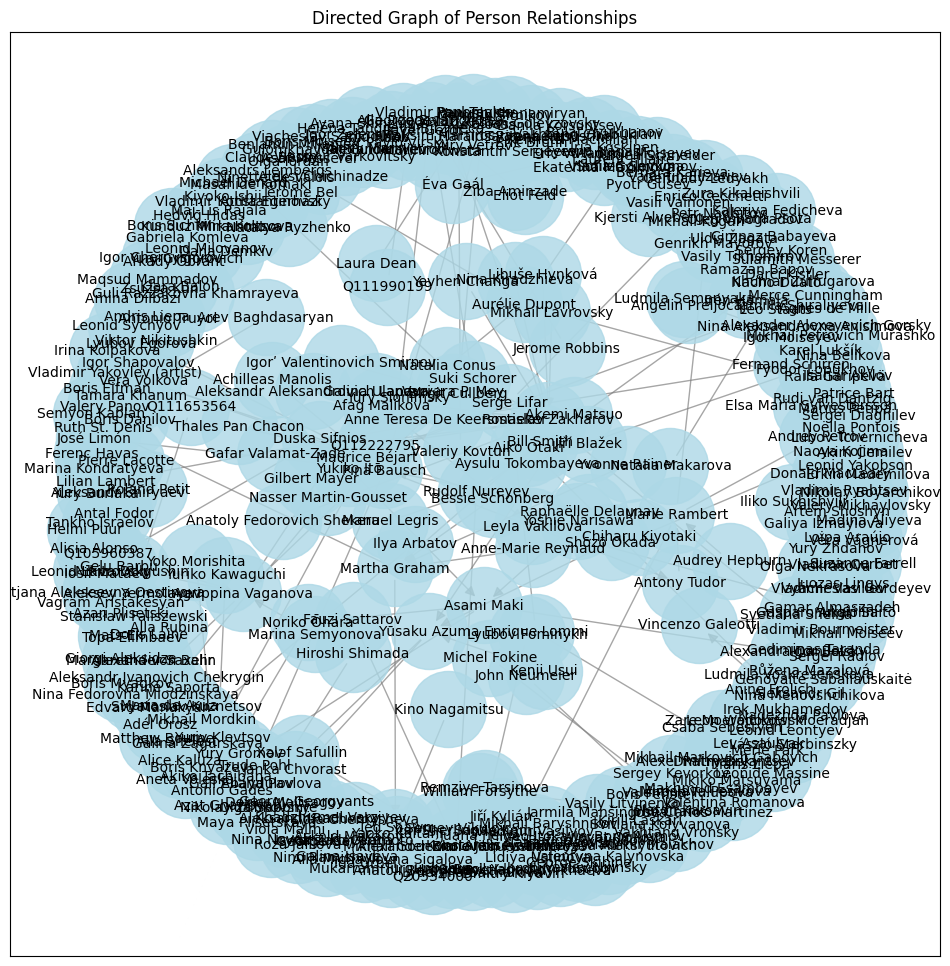

In [13]:
plt.figure(figsize=(12, 12))

# Use spring layout or another layout depending on the structure of your graph
pos = nx.spring_layout(G, k=0.3)  # k controls the distance between nodes, you can adjust it

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', alpha=0.8)

# Draw the edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='gray', alpha=0.7)

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Optional: Draw edge labels if you have weights or specific labels for edges
# edge_labels = nx.get_edge_attributes(G, 'label')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title('Directed Graph of Person Relationships')
plt.show()

### **1. Betweenness Centrality**
**Definition:**
Betweenness centrality measures how often a node (individual) appears on the shortest paths between other nodes in a network. It indicates the extent to which a person acts as a bridge or intermediary in the flow of information or influence between others.

**Interpretation:**
- A high betweenness centrality score means that the individual is a critical connector in the network, often facilitating interactions between other people. This person might control the flow of information or resources, making them influential in connecting different groups.
- For example, in a mentorship network, a person with high betweenness centrality might be someone who connects various groups of students or teachers, playing a crucial role in spreading knowledge or influence across the network.

### **2. Closeness Centrality**
**Definition:**
Closeness centrality measures how close a node is to all other nodes in the network. It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes. Essentially, it reflects how quickly an individual can access every other person in the network.

**Interpretation:**
- A high closeness centrality score indicates that the individual is close to all other members of the network, meaning they can quickly interact or spread information to others. They are efficiently positioned to reach out to others with minimal steps.
- In a mentorship network, a person with high closeness centrality might be someone who can easily influence or be influenced by others due to their proximity (in a network sense) to everyone else.

### **3. Eigenvector Centrality**
**Definition:**
Eigenvector centrality is a measure of a node's influence in a network, considering not just the number of connections (like degree centrality) but also the quality of those connections. A node is considered influential if it is connected to other nodes that are themselves influential.

**Interpretation:**
- A high eigenvector centrality score suggests that the individual is well-connected to other well-connected individuals, making them highly influential within the network. This metric identifies not just direct influence but also indirect influence through the network.
- In a mentorship network, someone with high eigenvector centrality might be a mentor who has not only many students but also students who themselves are or become influential, amplifying the mentor's overall influence in the network.

### **Summary:**
- **Betweenness Centrality**: Identifies key connectors or intermediaries in the network.
- **Closeness Centrality**: Measures how easily a person can reach others in the network.
- **Eigenvector Centrality**: Evaluates influence based on both direct and indirect connections, giving more weight to connections with influential individuals.


In [9]:
centrality_df

,Name,In-Degree Centrality,Out-Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,Çimnaz Babayeva,0.000000,0.000000,0.0,0.000000,5.227762e-09
1,Éric Vu-An,0.000000,0.000000,0.0,0.000000,5.227762e-09
2,Éva Gaál,0.000000,0.002618,0.0,0.000000,5.227762e-09
3,Adél Orosz,0.000000,0.000000,0.0,0.000000,5.227762e-09
4,Agnes de Mille,0.000000,0.000000,0.0,0.000000,5.227762e-09
...,...,...,...,...,...,...
378,Trude Pohl,0.002618,0.000000,0.0,0.003490,1.352893e-04
379,Sergeĭ Radlov,0.002618,0.000000,0.0,0.016390,1.476263e-03
380,Q111020258,0.002618,0.000000,0.0,0.002618,1.191930e-06
381,Gasparo Angiolini,0.002618,0.000000,0.0,0.003490,1.352893e-04


In [10]:
data = pd.merge(centrality_df,df,on='Name')

In [11]:
data

,Name,In-Degree Centrality,Out-Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,QID,num_links,ballet_master,country_of_citizenship,...,educatedat,studentofLabel,studentLabel,influence,award,num_awards,num_countries,num_influences,num_employer,num_education
0,Çimnaz Babayeva,0.0,0.000000,0.0,0.0,5.227762e-09,Q12848543,2.0,Çimnaz Babayeva,Azerbaijan; Russia,...,Azerbaijan State Academic Opera and Ballet The...,NaN,NaN,NaN,Honored Artist of the Azerbaijan SSR; People's...,3,2,0,1,2
1,Éric Vu-An,0.0,0.000000,0.0,0.0,5.227762e-09,Q3591402,7.0,Éric Vu-An,France,...,Paris Opera,NaN,NaN,NaN,Officer of the Legion of Honour; Knight of the...,5,1,0,0,1
2,Éva Gaál,0.0,0.002618,0.0,0.0,5.227762e-09,Q109781409,3.0,Éva Gaál,Hungary,...,NaN,Ferenc Nádasi,NaN,Ferenc Nádasi,Franz Liszt Prize; Meritorius Artist of Hungary,2,1,1,0,0
3,Adél Orosz,0.0,0.000000,0.0,0.0,5.227762e-09,Q1225751,3.0,Adél Orosz,Hungary,...,NaN,NaN,NaN,NaN,Great Artist of Hungary Award; Kossuth Prize; ...,6,1,0,0,0
4,Agnes de Mille,0.0,0.000000,0.0,0.0,5.227762e-09,Q394670,19.0,Agnes de Mille,United States of America,...,"University of California, Los Angeles; Califor...",NaN,NaN,NaN,Tony Award for Best Choreography; Kennedy Cent...,6,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,Yury Zhdanov,0.0,0.000000,0.0,0.0,5.227762e-09,Q4178491,11.0,Yury Zhdanov,Russia,...,Russian Institute of Theatre Arts,NaN,NaN,NaN,People's Artist of the RSFSR; Order of the Red...,3,1,0,1,1
300,Zare Moeradovitsj Moeradjan,0.0,0.000000,0.0,0.0,5.227762e-09,Q4307808,5.0,Zare Moeradovitsj Moeradjan,Russia,...,Moscow State Academy of Choreography; Yerevan ...,NaN,NaN,NaN,Order of the Badge of Honour; Honored Art Work...,2,1,0,6,3
301,Ziba Aminzade,0.0,0.000000,0.0,0.0,5.227762e-09,Q15064009,3.0,Ziba Aminzade,Tajikistan; Russia,...,NaN,NaN,NaN,NaN,People's Artist of the USSR; People's Artist o...,2,2,0,0,0
302,Zsuzsa Kun,0.0,0.000000,0.0,0.0,5.227762e-09,Q617902,2.0,Zsuzsa Kun,Hungary,...,NaN,NaN,NaN,NaN,Great Artist of Hungary Award; Kossuth Prize; ...,4,1,0,0,0


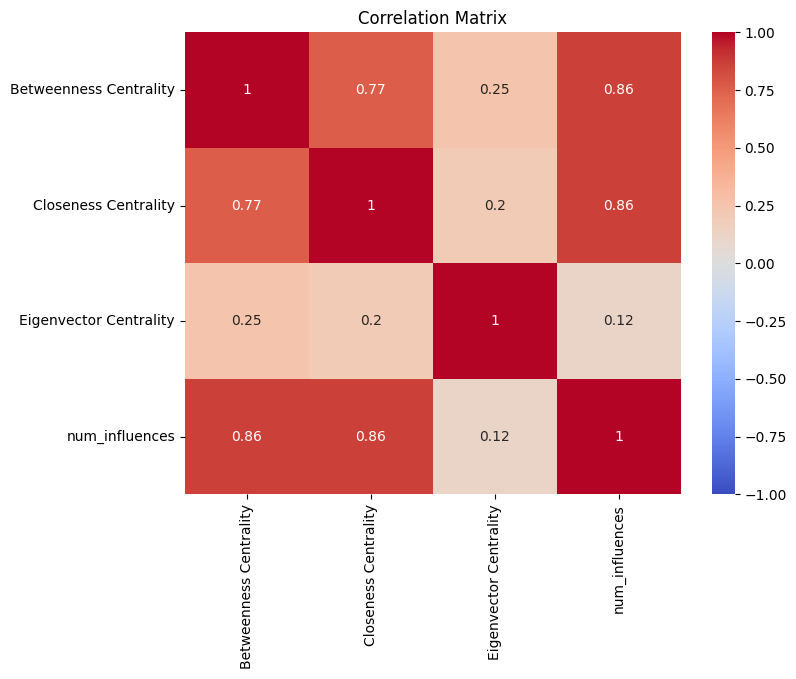

In [12]:
import seaborn as sns
corr_matrix = data[['Betweenness Centrality',	'Closeness Centrality'	,'Eigenvector Centrality', 'num_influences']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

/var/folders/xf/m7s8z1812_j3lvq4zs2f3z7w0000gn/T/ipykernel_45597/1122865331.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)


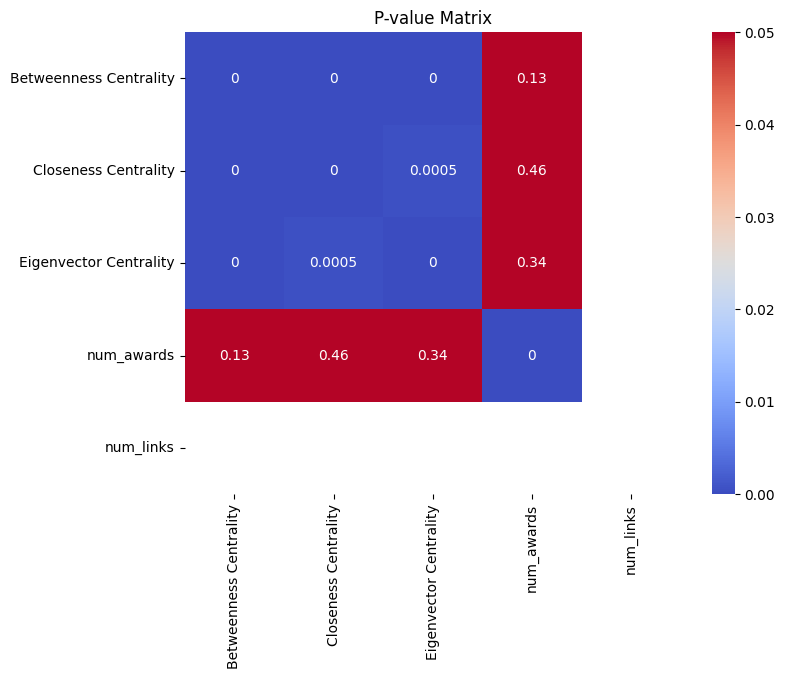

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pval_matrix = calculate_pvalues(data[['Betweenness Centrality',	'Closeness Centrality'	,'Eigenvector Centrality', 'num_awards', 'num_links']])

plt.figure(figsize=(8, 6))
sns.heatmap(pval_matrix.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=0.05)
plt.title('P-value Matrix')
plt.show()

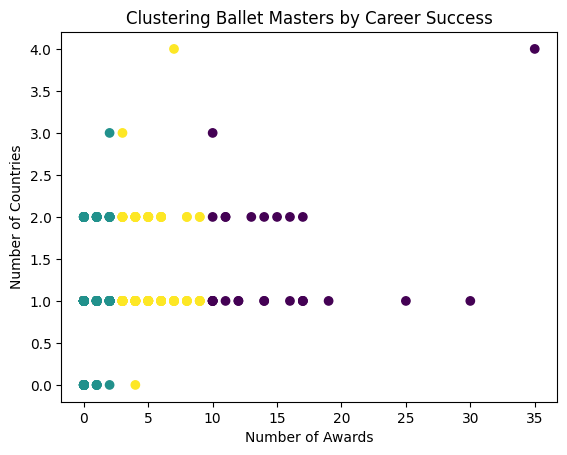

                         Name  cluster
0             Çimnaz Babayeva        2
1                  Éric Vu-An        2
2                    Éva Gaál        1
4    Aage Thordal-Christensen        1
5             Achille Viscusi        1
..                        ...      ...
648            Zdeněk Doležal        1
649             Ziba Aminzade        1
650                Zsuzsa Kun        2
651         Zsuzsa L. Merényi        1
652        Zura Kikaleishvili        2

[462 rows x 2 columns]


In [64]:
X = df[['num_awards', 'num_countries', 'num_employer', 'num_education']].fillna(0)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
df['cluster'] = kmeans.labels_

# Visualize clusters
plt.scatter(df['num_awards'], df['num_countries'], c=df['cluster'], cmap='viridis')
plt.xlabel('Number of Awards')
plt.ylabel('Number of Countries')
plt.title('Clustering Ballet Masters by Career Success')
plt.show()

# Display cluster assignments
print(df[['Name', 'cluster']])

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Features and target variable (number of awards)
X = df[['num_countries', 'num_influences', 'num_employer', 'num_education']].fillna(0)
y = df['num_awards']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Predicted Awards: {y_pred}')


Mean Squared Error: 15.174401598379701
Predicted Awards: [ 7.4406692   3.22086171  2.97635418  3.22086171  1.38074928  1.09724567
 -0.21485562  2.97635418  5.20006493  2.5984419   1.09724567  1.26992408
  2.69285058  1.15909888  4.532963    1.38074928  5.06097413  5.06097413
 -0.21485562  6.37307543  2.97635418  2.97635418  4.44499494  1.38074928
  3.22086171  6.08957182  1.38074928 -0.21485562  4.72205793  2.88838611
 -0.21485562  0.70291687 -0.21485562  0.53023846  3.22086171  1.32533668
  1.38074928  1.38074928  4.81646661  3.22086171  2.9373581   3.22086171
 -0.21485562  2.9373581   2.97635418  3.92695971  1.38074928  2.9373581
  2.92094158  5.24550162 -0.21485562  5.06097413  1.38074928  1.26992408
  2.9373581   2.6538545   1.38074928  7.96868033  8.10777113  1.09724567
  0.81374207 -0.21485562  2.88838611  6.37307543  1.38074928  1.38074928
  2.9373581   1.09724567  5.00556153  0.75832947  1.04183308  1.21451148
  4.76105401  1.3417532   0.70291687  2.8819455   4.532963    3.2208

/var/folders/xf/m7s8z1812_j3lvq4zs2f3z7w0000gn/T/ipykernel_54869/1789775086.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_awards.index, y=gender_awards.values, palette='coolwarm')


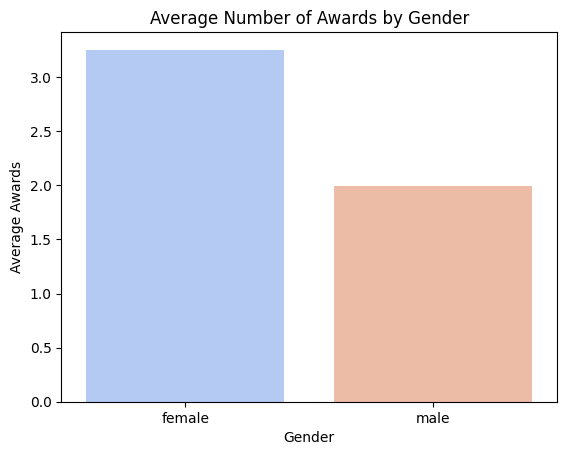

In [66]:
import seaborn as sns

# Group by gender and calculate the average number of awards
gender_awards = df.groupby('gender')['num_awards'].mean()

# Plot the results
sns.barplot(x=gender_awards.index, y=gender_awards.values, palette='coolwarm')
plt.title('Average Number of Awards by Gender')
plt.ylabel('Average Awards')
plt.xlabel('Gender')
plt.show()


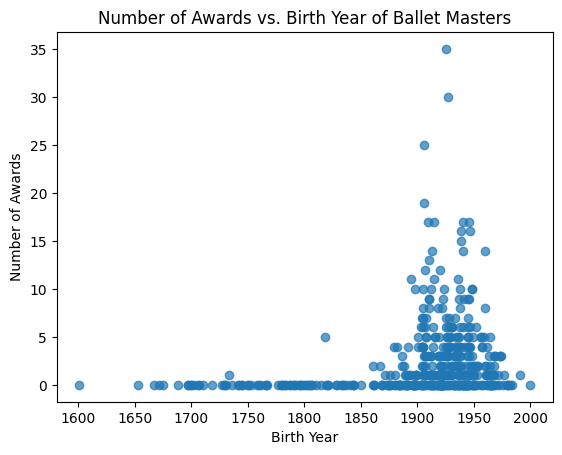

            birth_year  num_awards
birth_year    1.000000    0.223254
num_awards    0.223254    1.000000


In [67]:
# Analyze the relationship between birth year and number of awards
df['birth_year'] = pd.to_numeric(df['birth_year'], errors='coerce')

plt.scatter(df['birth_year'], df['num_awards'], alpha=0.7)
plt.xlabel('Birth Year')
plt.ylabel('Number of Awards')
plt.title('Number of Awards vs. Birth Year of Ballet Masters')
plt.show()

# You can also calculate correlation
correlation = df[['birth_year', 'num_awards']].corr()
print(correlation)



### Key Points of the Correlation Matrix:

1. **Correlation Coefficient Values**:
   - **1**: Perfect positive correlation. As one variable increases, the other variable increases in a perfectly linear manner.
   - **0**: No correlation. There is no linear relationship between the variables.
   - **-1**: Perfect negative correlation. As one variable increases, the other decreases in a perfectly linear manner.

2. **Interpretation of Values**:
   - **0.7 to 1.0 or -0.7 to -1.0**: Strong positive or negative correlation.
   - **0.5 to 0.7 or -0.5 to -0.7**: Moderate positive or negative correlation.
   - **0.3 to 0.5 or -0.3 to -0.5**: Weak positive or negative correlation.
   - **0.0 to 0.3 or -0.0 to -0.3**: Very weak or negligible correlation.

3. **Understanding the Matrix**:
   - The diagonal of the matrix always shows 1s because any variable is perfectly correlated with itself.
   - The matrix is symmetric, meaning the value at position (i, j) is the same as at (j, i).

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ballet_master           651 non-null    object 
 1   country_of_citizenship  519 non-null    object 
 2   employer                189 non-null    object 
 3   birth_year              628 non-null    float64
 4   gender                  651 non-null    object 
 5   educatedat              214 non-null    object 
 6   studentofLabel          88 non-null     object 
 7   studentLabel            63 non-null     object 
 8   influence               116 non-null    object 
 9   award                   302 non-null    object 
 10  num_awards              651 non-null    int64  
 11  num_countries           651 non-null    int64  
 12  num_influences          651 non-null    int64  
 13  num_employer            651 non-null    int64  
 14  num_education           651

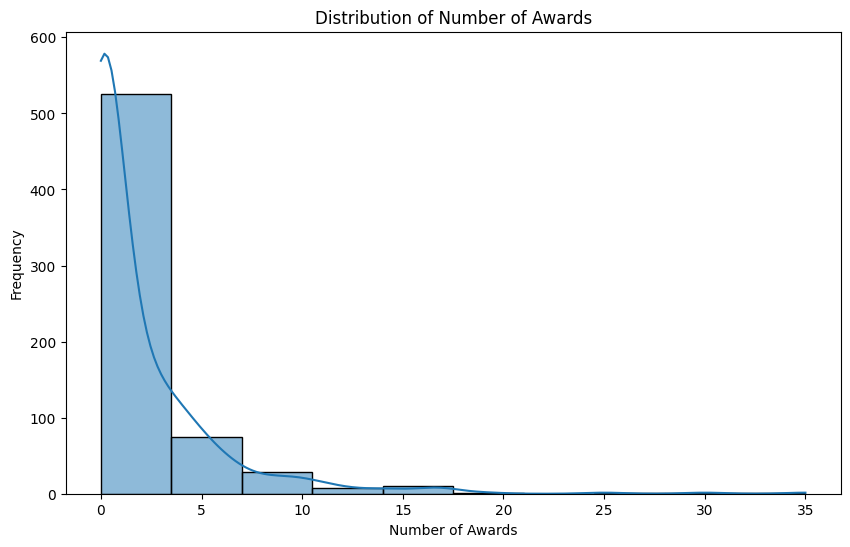

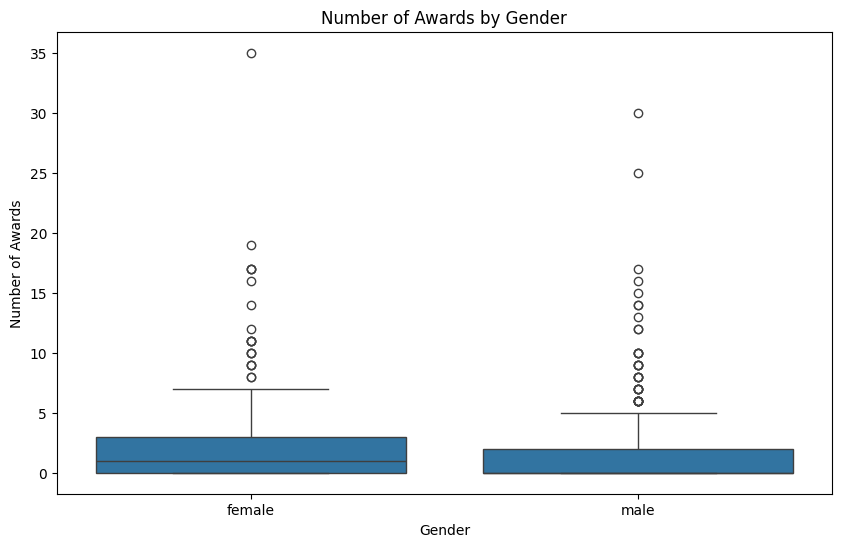

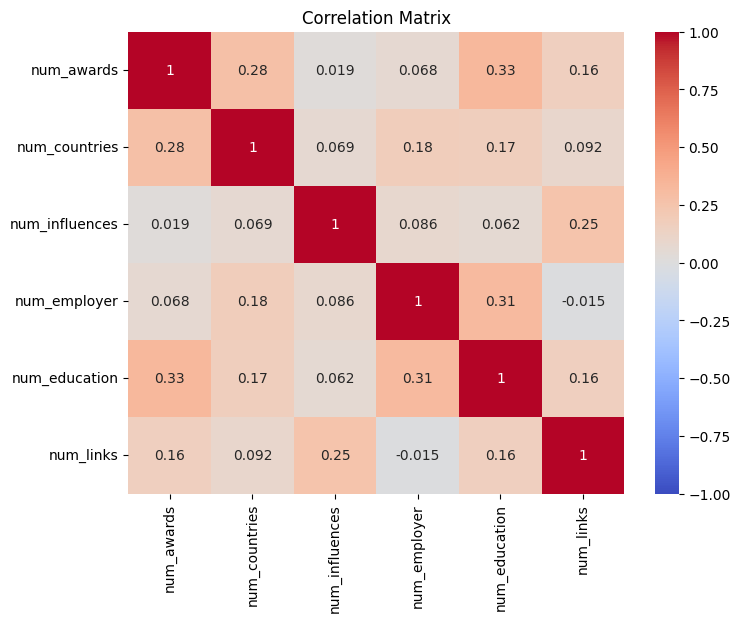

Top 10 Award-Winning Ballet Masters:
                    ballet_master  num_awards  \
402              Maya Plisetskaya          35   
638              Yury Grigorovich          30   
225                 Igor Moiseyev          25   
553                 Tamara Khanum          19   
101                  Boris Eifman          17   
539               Sofia Golovkina          17   
560  Tatjana Alekseevna Oestinova          17   
492                   Pina Bausch          17   
579            Valentin Elizariev          16   
139            Ekaterina Maximova          16   

                country_of_citizenship                           employer  \
402  Russia; Spain; Lithuania; Germany                                NaN   
638                             Russia                  Mariinsky Theatre   
225                             Russia                                NaN   
553                             Russia                      Navoi Theater   
101                             Russia

In [68]:
# Load the dataset
data = pd.read_csv('balletmasters_final.csv')

# General Overview of the Data
print("Data Overview:")
print(data.info())

# 1. Distribution of Number of Awards
plt.figure(figsize=(10, 6))
sns.histplot(data['num_awards'], bins=10, kde=True)
plt.title('Distribution of Number of Awards')
plt.xlabel('Number of Awards')
plt.ylabel('Frequency')
plt.show()

# 2. Analysis of Awards by Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='num_awards', data=data)
plt.title('Number of Awards by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Awards')
plt.show()

# # 3. Analysis of Awards by Country of Citizenship
# # Split countries and explode for multi-country ballet masters
# data['country_of_citizenship'] = data['country_of_citizenship'].str.split(';')
# data_exploded = data.explode('country_of_citizenship')

# plt.figure(figsize=(12, 8))
# country_awards = data_exploded.groupby('country_of_citizenship')['num_awards'].mean().sort_values(ascending=False)
# sns.barplot(x=country_awards.index, y=country_awards.values)
# plt.xticks(rotation=90)
# plt.title('Average Number of Awards by Country of Citizenship')
# plt.xlabel('Country')
# plt.ylabel('Average Number of Awards')
# plt.show()

# 4. Correlation Analysis
corr_matrix = df[['num_awards', 'num_countries', 'num_influences', 'num_employer', 'num_education', 'num_links']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# # 5. Analysis of Awards by Employment
# plt.figure(figsize=(12, 8))
# employer_awards = data.groupby('employer')['num_awards'].mean().sort_values(ascending=False)
# sns.barplot(x=employer_awards.index, y=employer_awards.values)
# plt.xticks(rotation=90)
# plt.title('Average Number of Awards by Employer')
# plt.xlabel('Employer')
# plt.ylabel('Average Number of Awards')
# plt.show()

# # 6. Analysis of Awards by Education
# plt.figure(figsize=(12, 8))
# education_awards = data.groupby('educatedat')['num_awards'].mean().sort_values(ascending=False)
# sns.barplot(x=education_awards.index, y=education_awards.values)
# plt.xticks(rotation=90)
# plt.title('Average Number of Awards by Educational Institution')
# plt.xlabel('Educational Institution')
# plt.ylabel('Average Number of Awards')
# plt.show()

# 7. Top Award-Winning Ballet Masters
top_award_winners = data.sort_values(by='num_awards', ascending=False).head(10)
print("Top 10 Award-Winning Ballet Masters:")
print(top_award_winners[['ballet_master', 'num_awards', 'country_of_citizenship', 'employer', 'educatedat']])


In the context of p-values:

- **p > 0.05** generally indicates that the result is **not statistically significant**. This means that the observed correlation or effect is likely to have occurred by random chance rather than being a true relationship.

### Understanding p-value:
- A p-value represents the probability of observing the given data, or something more extreme, assuming the null hypothesis is true (i.e., assuming there is no real effect or correlation).
- **p ≤ 0.05** typically suggests that the result is statistically significant, implying that there is evidence to reject the null hypothesis (there is likely a true effect or correlation).
- **p > 0.05** suggests that the evidence is not strong enough to reject the null hypothesis, indicating no statistically significant relationship.

### Example:
If a p-value is 0.06 (which is greater than 0.05), it would mean there is a 6% chance that the observed relationship happened purely by chance, and it’s not considered statistically significant according to the conventional threshold (0.05).

In practice, thresholds like 0.05 are somewhat arbitrary and depend on the context of the research, but they are commonly used to judge significance.

/var/folders/xf/m7s8z1812_j3lvq4zs2f3z7w0000gn/T/ipykernel_54869/1429094290.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)


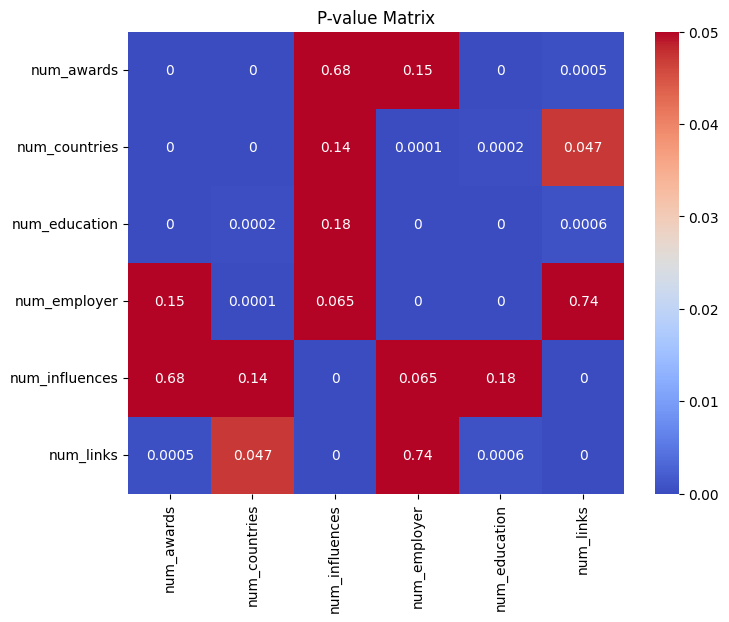

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pval_matrix = calculate_pvalues(df[['num_awards', 'num_countries', 'num_influences', 'num_employer', 'num_education', 'num_links']])

plt.figure(figsize=(8, 6))
sns.heatmap(pval_matrix.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=0.05)
plt.title('P-value Matrix')
plt.show()